In [20]:
## Step 1: Set Up

# Install necessary libraries
import keras
from keras import layers
from keras import ops

import os
import numpy as np
from glob import glob
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt

# For data preprocessing
import tensorflow as tf
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io

In [2]:
## Step 2: Prepare Dataset
import zipfile

with zipfile.ZipFile('car.zip', 'r') as zip_ref:
  zip_ref.extractall('car')

In [27]:
IMAGE_SIZE = 256
BATCH_SIZE = 16 #v1=4;v2=16
NUM_CLASSES = 5
DATA_DIR = "/content/car/car-segmentation"
NUM_TRAIN_IMAGES = 200
NUM_VAL_IMAGES = 11

train_images = sorted(glob(os.path.join(DATA_DIR, "images/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "masks/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "images/*")))[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]
val_masks = sorted(glob(os.path.join(DATA_DIR, "masks/*")))[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]


def read_image(image_path, mask=False):
    image = tf_io.read_file(image_path)
    if mask:
        image = tf_image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf_image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list, target_size):
    dataset = tf_data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.repeat()  # 重複資料集
    dataset = dataset.map(load_data, num_parallel_calls=tf_data.AUTOTUNE)  # 套用擴增操作
    dataset = dataset.shuffle(buffer_size=len(image_list))  # 打亂資料順序
    dataset = dataset.take(target_size)  # 取出目標數量資料
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)  # 批次化
    return dataset


train_dataset = data_generator(train_images, train_masks, target_size=1000)  # 產生 1000 張擴增資料
val_dataset = data_generator(val_images, val_masks, target_size=50)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 256, 256, 1), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 256, 256, 1), dtype=tf.float32, name=None))>


In [28]:
## Step 3: Define ERFNet Model
from keras import Model
import tensorflow as tf

def residual_block(x, filters):
    """Defines a Factorized Residual Block."""
    residual = x
    x = layers.Conv2D(filters, (1, 3), padding="same", activation="relu")(x)  # Horizontal convolution
    x = layers.Conv2D(filters, (3, 1), padding="same", activation="relu")(x)  # Vertical convolution
    return layers.Add()([x, residual])  # Add residual connection

def downsample_block(x, filters):
    """Defines a Downsampling Block."""
    x = layers.Conv2D(filters, 3, strides=2, padding="same", activation="relu")(x)  # Downsample
    return x

def upsample_block(x, filters):
    """Defines an Upsampling Block."""
    x = layers.Conv2DTranspose(filters, 3, strides=2, padding="same", activation="relu")(x)  # Upsample
    return x

def ERFNet(num_classes=20, input_shape=(256, 256, 3)):
    """Defines the ERFNet architecture."""
    input_layer = tf.keras.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(16, 3, strides=2, padding="same", activation="relu")(input_layer)  # Initial Downsampling
    x = residual_block(x, 16)
    x = downsample_block(x, 64)
    x = residual_block(x, 64)
    x = downsample_block(x, 128)
    x = residual_block(x, 128)

    # Decoder
    x = upsample_block(x, 64)
    x = residual_block(x, 64)
    x = upsample_block(x, 16)
    x = residual_block(x, 16)

    # Added another upsampling layer to match the input size
    x = layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(x)

    # Output Layer
    output_layer = layers.Conv2D(num_classes, 1, activation="softmax")(x)

    # Create Model
    model = Model(inputs=input_layer, outputs=output_layer, name="ERFNet")
    return model

# Instantiate the ERFNet model
num_classes = 5  # car dataset has 20 categories
input_shape = (256, 256, 3)  # Example input size
model = ERFNet(num_classes=num_classes, input_shape=input_shape)

model.summary()  # Print model summary to check the architecture

Model: "ERFNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_70 (Conv2D)        │ (None, 128, 128, 16)   │            448 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_71 (Conv2D)        │ (None, 128, 128, 16)   │            784 │ conv2d_70[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_72 (Conv2D)        │ (None, 128, 128, 16)   │            784 │ conv2d_71[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_25 (Add)              │ (None, 128, 128, 16)   │              0 │ conv2d_72[0][0],       │
│                           │                        │                │ conv2d_70[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_73 (Conv2D)        │ (None, 64, 64, 64)     │          9,280 │ add_25[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_74 (Conv2D)        │ (None, 64, 64, 64)     │         12,352 │ conv2d_73[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_75 (Conv2D)        │ (None, 64, 64, 64)     │         12,352 │ conv2d_74[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_26 (Add)              │ (None, 64, 64, 64)     │              0 │ conv2d_75[0][0],       │
│                           │                        │                │ conv2d_73[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_76 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ add_26[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_77 (Conv2D)        │ (None, 32, 32, 128)    │         49,280 │ conv2d_76[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_78 (Conv2D)        │ (None, 32, 32, 128)    │         49,280 │ conv2d_77[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_27 (Add)              │ (None, 32, 32, 128)    │              0 │ conv2d_78[0][0],       │
│                           │                        │                │ conv2d_76[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_15       │ (None, 64, 64, 64)     │         73,792 │ add_27[0][0]           │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_79 (Conv2D)        │ (None, 64, 64, 64)     │         12,352 │ conv2d_transpose_15[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_80 (Conv2D)        │ (None, 64, 64, 64)     │         12,352 │ conv2d_79[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_28 (Add)              │ (None, 64, 64, 64)     │              0 │ conv2d_80[0][0],       │
│                      

 Total params: 320,117 (1.22 MB)

 Trainable params: 320,117 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 137s 963ms/step - accuracy: 0.3395 - loss: 2.0978 - val_accuracy: 0.7241 - val_loss: 0.7743
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 66s 947ms/step - accuracy: 0.6428 - loss: 0.8775 - val_accuracy: 0.7302 - val_loss: 0.6670
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 66s 929ms/step - accuracy: 0.7063 - loss: 0.7459 - val_accuracy: 0.7834 - val_loss: 0.6163
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 83s 926ms/step - accuracy: 0.7480 - loss: 0.6518 - val_accuracy: 0.7744 - val_loss: 0.5613
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 81s 918ms/step - accuracy: 0.7847 - loss: 0.5769 - val_accuracy: 0.8289 - val_loss: 0.4865
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 921ms/step - accuracy: 0.8174 - loss: 0.5029 - val_accuracy: 0.8358 - val_loss: 0.4864
Epoch 7/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 66s 921ms/step - accuracy: 0.8306 - loss: 0.4701 - val_accuracy: 0.8039 - val_loss: 0.5500
Epoch 8/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 940ms/step - accuracy: 0.8451 - loss: 0.4241 - val_acc

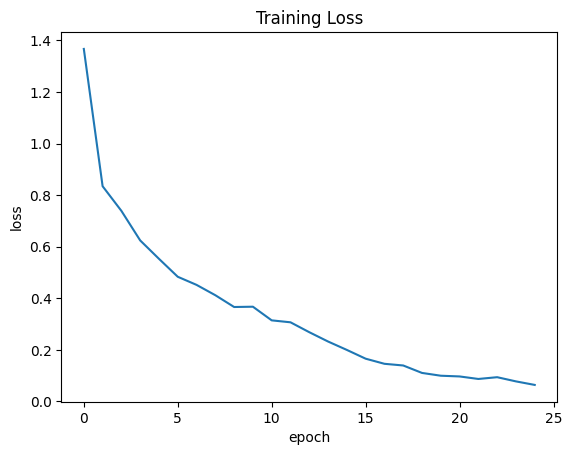

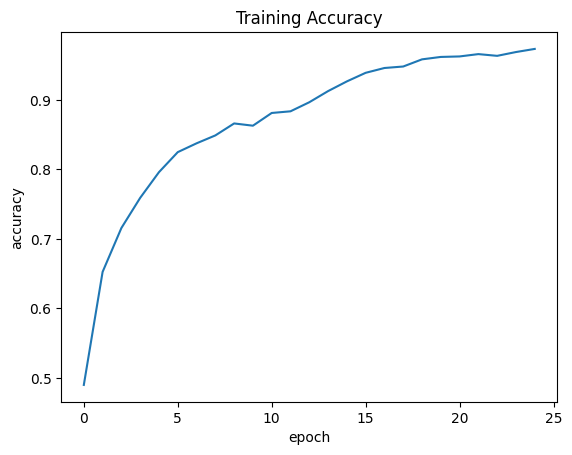

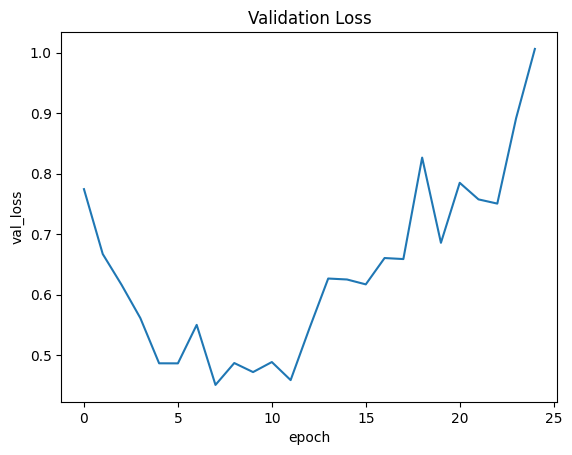

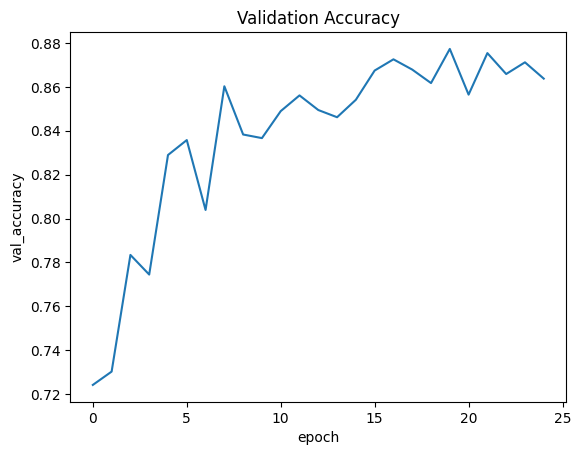

In [29]:
## Step 4: Train the Model
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=25)  #v1=25;v2=50

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [30]:
## Step 5: Save the Model
model.save('erfnet_model_car_v2.keras')